# Libraries

In [1]:
! pip install vaderSentiment
! pip install swifter

Defaulting to user installation because normal site-packages is not writeable
  Using cached vaderSentiment-3.3.2-py2.py3-none-any.whl.metadata (572 bytes)
Using cached vaderSentiment-3.3.2-py2.py3-none-any.whl (125 kB)
Defaulting to user installation because normal site-packages is not writeable
  Using cached swifter-1.4.0-py3-none-any.whl


In [2]:
import pandas as pd
import seaborn as sns
from os.path import exists
from os import remove
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import swifter
import numpy as np

# Loading the Files

Download the csv files into the `data/` directory.

In [3]:
sample_csv = "sample.csv"
test_csv = "test.csv"
train_csv = "train.csv"

processed_test_csv = "processed_test.csv"
processed_train_csv = "processed_train.csv"

submission_csv = "submission.csv"

In [4]:
def clean_cache():
    if exists(processed_test_csv):
        remove(processed_test_csv)
    if exists(processed_train_csv):
        remove(processed_train_csv)
    if exists(submission_csv):
        remove(submission_csv)
        
clean_cache()

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

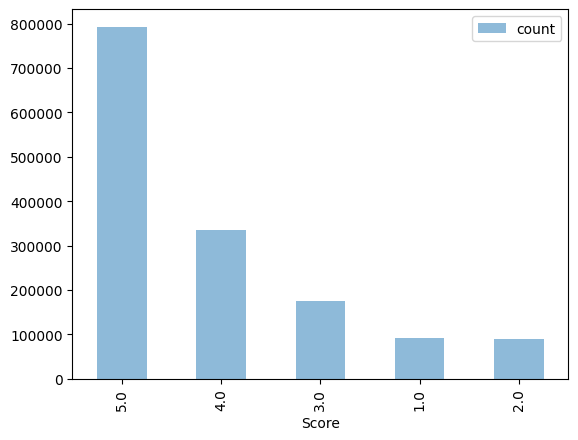


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [5]:
trainingSet = pd.read_csv(train_csv)
testingSet = pd.read_csv(test_csv)

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [6]:
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    return analyzer.polarity_scores(text)

def length(text):
    return len(text)

def add_features_to(df):
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    df['Text'] = df['Text'].fillna('').astype(str)
    df_sentiment = df['Text'].swifter.apply(analyze_sentiment).swifter.apply(pd.Series)
    df_sentiment = df_sentiment.add_prefix('Text_Sentiment_')
    df = pd.concat([df, df_sentiment], axis=1)
    df['Text_Length'] = df['Text'].swifter.apply(length)
    
    df['Summary'] = df['Summary'].fillna('').astype(str)
    df_sentiment = df['Summary'].swifter.apply(analyze_sentiment).swifter.apply(pd.Series)
    df_sentiment = df_sentiment.add_prefix('Summary_Sentiment_')
    df = pd.concat([df, df_sentiment], axis=1)
    df['Summary_Length'] = df['Summary'].swifter.apply(length)
                                           
    product_stat = df.groupby('ProductId')['Score'].agg(['count', 'mean', 'std']).reset_index()
    product_stat.columns = ['ProductId', 'Count_Score_movie', 'Mean_Score_movie', 
                        'Std_Score_movie']
    
    product_stat['Std_Score_movie'] = product_stat['Std_Score_movie'].fillna(0)

    user_stat = df.groupby('UserId')['Score'].agg(['count', 'mean', 'std']).reset_index()
    user_stat.columns = ['UserId', 'Count_Score_user', 'Mean_Score_user', 
                     'Std_Score_user']
    
    user_stat['Std_Score_user'] = user_stat['Std_Score_user'].fillna(0)
                                           
    df = df.merge(product_stat, on='ProductId', how='left')
    df = df.merge(user_stat, on='UserId', how='left')
                                           
    return df

# Load the feature extracted files if they've already been generated
if exists(processed_test_csv):
    X_train = pd.read_csv(processed_test_csv)
if exists(processed_test_csv):
    X_submission = pd.read_csv(processed_test_csv)

else:
    train = add_features_to(trainingSet)
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})
    X_train = train[train['Score'].notnull()]
    X_submission.to_csv(submission_csv, index=False)
    X_train.to_csv(processed_train_csv, index=False)

Pandas Apply:   0%|          | 0/1697533 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1697533 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1697533 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1697533 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1697533 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1697533 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
correlation_matrix = X_train.drop(columns=["ProductId","UserId","Summary","Text"]).corr()
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

# Feature Selection

In [ ]:
X = X_train.drop(columns=["ProductId","UserId","Summary","Text", "Score"])
y = X_train['Score']
X_submission_select = X_submission.drop(columns=["ProductId","UserId","Summary","Text", "Score"])

# Sample + Split into training and testing set

In [ ]:
na_check = X.isna().sum()
print(na_check)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Creation

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

y = y.astype(int)
if np.max(y) == 5:
    y = y - 1


model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1],
}

grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose = 2
)

grid_search.fit(X, y)

print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Model Evaluation

In [ ]:
# Evaluate your model on the testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
eval_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', **best_params)
eval_model.fit(X_train, Y_train)
Y_test_predictions = eval_model.predict(X_test)
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test + 1, Y_test_predictions + 1, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [ ]:
# Create the submission file
X_submission['Score'] = best_model.predict(X_submission_select)
X_submission['Score'] = X_submission['Score'] + 1
submission = X_submission[['Id', 'Score']]
submission.to_csv(submission_csv, index=False)
submission.to_csv('submission.csv', index=False)